            index      price
date                        
2011-11-15      1  25.180000
2011-11-16      2  25.190001
2011-11-17      3  25.190001
2011-11-18      4  24.430000
2011-11-21      5  23.690001


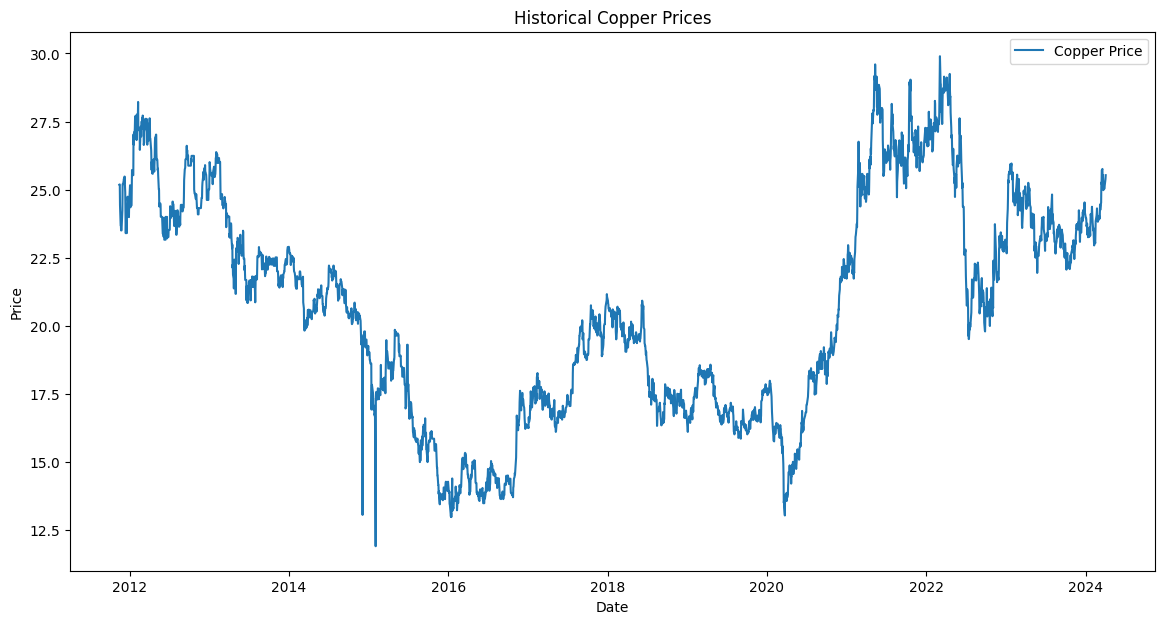

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


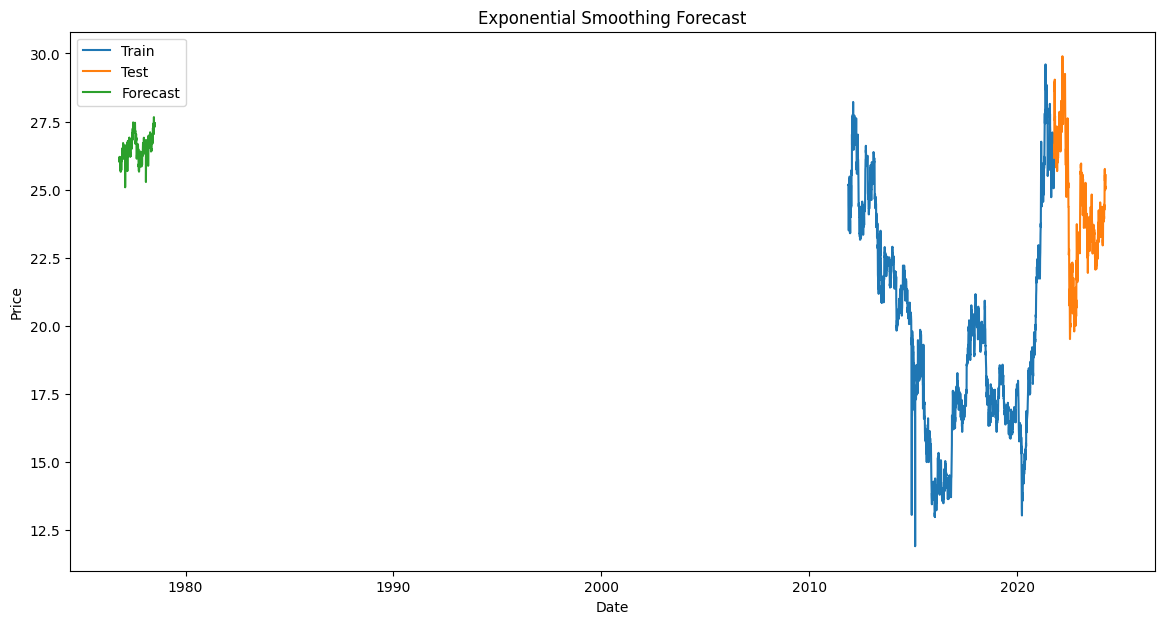

Epoch 1/10
2429/2429 - 86s - loss: 0.0022 - 86s/epoch - 36ms/step
Epoch 2/10
2429/2429 - 78s - loss: 8.2081e-04 - 78s/epoch - 32ms/step
Epoch 3/10
2429/2429 - 79s - loss: 6.6508e-04 - 79s/epoch - 32ms/step
Epoch 4/10
2429/2429 - 77s - loss: 5.6056e-04 - 77s/epoch - 32ms/step
Epoch 5/10
2429/2429 - 80s - loss: 5.6009e-04 - 80s/epoch - 33ms/step
Epoch 6/10
2429/2429 - 74s - loss: 5.2681e-04 - 74s/epoch - 30ms/step
Epoch 7/10
2429/2429 - 71s - loss: 5.2911e-04 - 71s/epoch - 29ms/step
Epoch 8/10
2429/2429 - 70s - loss: 4.6196e-04 - 70s/epoch - 29ms/step
Epoch 9/10
2429/2429 - 70s - loss: 4.7908e-04 - 70s/epoch - 29ms/step
Epoch 10/10
2429/2429 - 69s - loss: 4.9716e-04 - 69s/epoch - 28ms/step
18/18 [==============================] - 0s 18ms/step


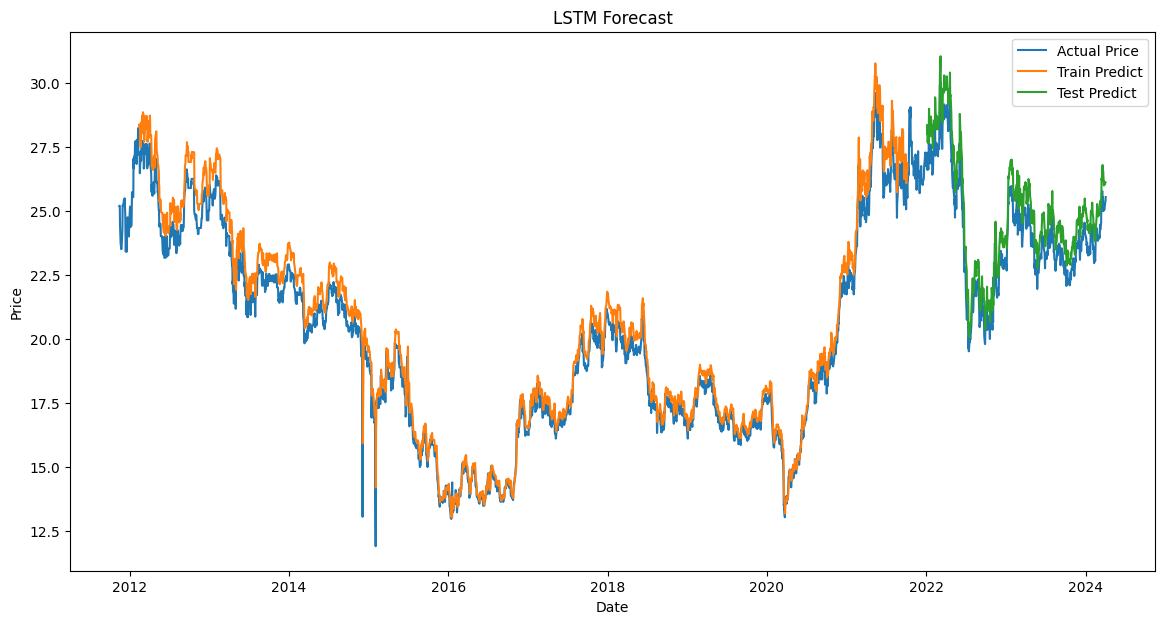

Exponential Smoothing - MSE: 11.166502287764509, MAE: 2.8459020204860837
Neural Network - MSE: 0.9505689142775737, MAE: 0.9044782563884886


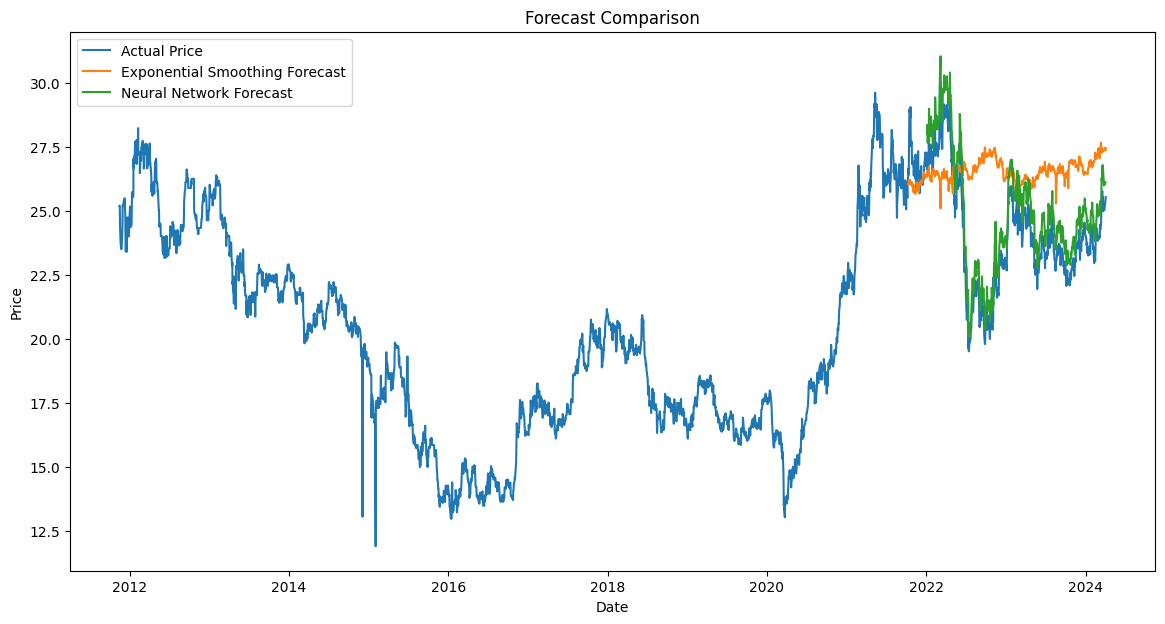

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Loading Data
url = 'https://drive.google.com/uc?export=download&id=1A4yzLQs4w8IfVkQ1ipqcKztPCqi0m84Q'
data = pd.read_csv(url, parse_dates=['date'])
data.set_index('date', inplace=True)

#Display
print(data.head())

#Historical copper prices plot
plt.figure(figsize=(14, 7))
plt.plot(data['price'], label='Copper Price')
plt.title('Historical Copper Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#Train/Test Split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

#Exponential Smoothing Model
model_es = ExponentialSmoothing(train['price'], trend='add', seasonal='add', seasonal_periods=365).fit()
forecast_es = model_es.forecast(steps=len(test))

#Forecast
plt.figure(figsize=(14, 7))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(forecast_es, label='Forecast')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#Data for LSTM preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['price'].values.reshape(-1, 1))

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

#Reshape input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Building LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=2)

#Prediction using model
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

#Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

#Plotting results
plt.figure(figsize=(14, 7))
plt.plot(data['price'], label='Actual Price')
plt.plot(data.index[look_back:train_size-1], train_predict[:, 0], label='Train Predict')
plt.plot(data.index[train_size+look_back:train_size+look_back+len(test_predict)], test_predict[:, 0], label='Test Predict')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#Performance metrics
mse_es = mean_squared_error(test['price'], forecast_es)
mae_es = mean_absolute_error(test['price'], forecast_es)

mse_nn = mean_squared_error(Y_test, test_predict)
mae_nn = mean_absolute_error(Y_test, test_predict)

print(f"Exponential Smoothing - MSE: {mse_es}, MAE: {mae_es}")
print(f"Neural Network - MSE: {mse_nn}, MAE: {mae_nn}")

#Visual Comparison
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['price'], label='Actual Price')
plt.plot(test.index, forecast_es, label='Exponential Smoothing Forecast')
plt.plot(data.index[train_size+look_back:train_size+look_back+len(test_predict)], test_predict[:, 0], label='Neural Network Forecast')
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [4]:
#For illustration, let's assume Exponential Smoothing is the better model
best_forecast = forecast_es if mse_es < mse_nn else test_predict[:, 0]

#Future prices
scenarios = {
    'Strong Growth': best_forecast[-1] * 1.20,
    'Moderate Growth': best_forecast[-1] * 1.10,
    'Weak Growth': best_forecast[-1] * 0.90
}

for scenario, price in scenarios.items():
    print(f"Scenario: {scenario}, Predicted Copper Price: ${price:.2f}/lb")

#Policy recommendations
print("\nPolicy Recommendations:")
print("1. Increase Recycling: Higher copper prices make recycling more viable economically.")
print("2. Invest in Alternatives: Encourage research in alternative materials to copper.")
print("3. Strategic Reserves: Countries like China should build reserves to stabilize supply.")
print("4. Sustainable Practices: Promote sustainable mining practices globally.")
print("5. Green Technology Funding: Invest in R&D for technologies that use copper efficiently.")


Scenario: Strong Growth, Predicted Copper Price: $31.32/lb
Scenario: Moderate Growth, Predicted Copper Price: $28.71/lb
Scenario: Weak Growth, Predicted Copper Price: $23.49/lb

Policy Recommendations:
1. Increase Recycling: Higher copper prices make recycling more viable economically.
2. Invest in Alternatives: Encourage research in alternative materials to copper.
3. Strategic Reserves: Countries like China should build reserves to stabilize supply.
4. Sustainable Practices: Promote sustainable mining practices globally.
5. Green Technology Funding: Invest in R&D for technologies that use copper efficiently.
